# 0. Import the necessary libraries

In [31]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import scipy.optimize
import statsmodels.stats
import scipy.stats
from tqdm.notebook import tqdm

EPS = np.finfo(np.float).eps

# 1. Define your experiment: Task model

## Bandit task

Parameters: 
* Number of option ($N$)
* Distribution of probability over these options ($\{p_{reward}(i)\}_{i\in N}$)
* Number of trials ($T$)

In [32]:
N = 2
P = np.array([0.5, 0.75])
T = 100

# 2. Define your decision-making models: Cognitive model

## Random

* Decision rule ($\tau$)

\begin{equation}
p_{choice}(i) \sim \text{Uniform}
\end{equation} 

* Updating rule

[None]

## Rescola-Wagner RL

* Decision rule ($\tau$)

\begin{equation}
p_{choice}(i) = \dfrac{\exp (v(i)/\tau)}{\sum_{j \in N} \exp (v(j)/\tau)} 
\end{equation}

* Updating rule ($\alpha$)

\begin{equation}
v^{t+1}(i) = v^t(i) + \alpha(s - v^t(i))
\end{equation}

In [33]:
class Random:
    
    """
    No-learning model
    """
    
    def __init__(self, n_option):
        self.n_option = n_option
        self.options = np.arange(n_option)
        
    def choose(self):
        p =  self.decision_rule()
        return np.random.choice(self.options, p=p)
        
    def learn(self, i, success):
        self.updating_rule(i, success)
    
    def decision_rule(self):
        return np.ones(self.n_option) / self.n_option
    
    def updating_rule(self, i, success):
        pass
        

In [34]:
class RL(Random):
    
    """
    Reinforcement learning model
    """
    
    def __init__(self, learning_rate, temp, n_option, initial_value=0.5):
        super().__init__(n_option=n_option)
        self.values = np.full(n_option, initial_value)
        self.learning_rate = learning_rate
        self.temp = temp
    
    def decision_rule(self):
        return np.exp(self.values/self.temp) / \
               np.sum(np.exp(self.values/self.temp))
        
    def updating_rule(self, i, success):
        self.values[i] += self.learning_rate * (success - self.values[i])

# 3. Simulate 

In [35]:
def run_simulation(agent_model, param, n_iteration, n_option,
                   prob_dist):
    
    if param is not None:
        agent = agent_model(n_option=n_option, *param)
    else:
        agent = agent_model(n_option=n_option)
    
    choices = np.zeros(n_iteration, dtype=int)
    successes = np.zeros(n_iteration, dtype=bool)
    
    # Simulate the task
    for t in range(n_iteration):
        
        # Determine choice
        choice = agent.choose()
        
        # Determine success
        p_success = prob_dist[choice]
        success = np.random.choice([0, 1], p=np.array([1-p_success, p_success]))
        
        # Make agent learn
        agent.learn(i=choice, success=success)
        
        # Backup
        choices[t] = choice
        successes[t] = success
    
    return choices, successes

In [36]:
np.random.seed(0)

learning_rate, temp = 0.01, 0.1

models = Random, RL
params = None, (learning_rate, temp)

n_models = len(models)

hist_choices = {}
hist_successes = {}

# Simulate the task
for i in range(n_models):
    
    m = models[i]
    
    choices, successes = run_simulation(
        agent_model=m, param=params[i],
        n_iteration=T, n_option=N, prob_dist=P)
    
    hist_choices[m.__name__] = choices
    hist_successes[m.__name__] = successes

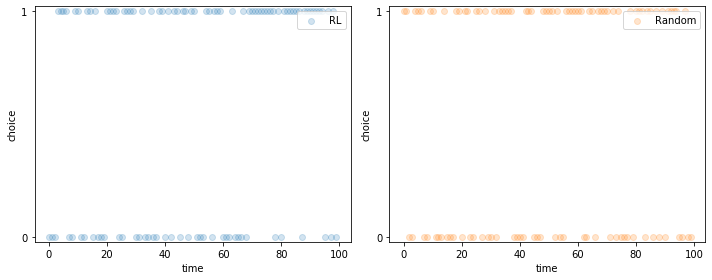

In [37]:
def basic_scatter(data, y_label="choice", x_label="time"):

    keys = sorted(data.keys())
    n_keys = len(keys)

    fig, axes = plt.subplots(ncols=n_keys, figsize=(10, 4))

    colors = [f'C{i}' for i in range(n_keys)]

    for i in range(n_keys):

        k = keys[i]
        y = data[k]

        ax = axes[i]
        ax.scatter(range(len(y)), y, color=colors[i],
                   alpha=0.2, label=k)

        ax.set_ylim(-0.02, 1.02)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend()

    plt.tight_layout()
    plt.show()

basic_scatter(data=hist_choices)

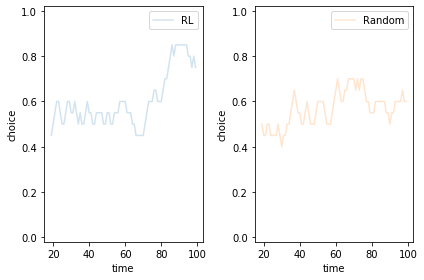

In [38]:
def running_mean(data, y_label='choice', x_label="time", window=20):

    keys = sorted(data.keys())
    n_keys = len(keys)

    fig, axes = plt.subplots(ncols=n_keys)

    colors = [f'C{i}' for i in range(n_keys)]

    for i in range(n_keys):

        k = keys[i]

        y = data[k]

        ax = axes[i]
        ax.plot(pd.Series(y).rolling(window).mean(),
                color=colors[i], alpha=0.2, label=k)
        ax.set_ylim(-0.02, 1.02)

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

        ax.legend()
    plt.tight_layout()
    plt.show()

running_mean(data=hist_choices)

In [39]:
import statsmodels.stats.proportion 
import scipy.stats
for i in range(n_models):
    
    m = models[i]
    choices = hist_choices[m.__name__]
    
    k, n = np.sum(choices), len(choices)
    print(statsmodels.stats.proportion.proportion_confint(count=k, nobs=n))
    freq_yes = k/n
    freq_no = 1- freq_yes
    chi2, p = scipy.stats.chisquare((k, n-k))
    print(chi2, p)

(0.4627099463758483, 0.6572900536241518)
1.44 0.23013934044341314
(0.5039817664728937, 0.6960182335271062)
4.0 0.04550026389635857


In [40]:
class BanditOptimizer:
    
    def __init__(self,
                 n_option, 
                 choices,
                 successes,
                 model, bounds=None):
        
        self.n_option = n_option
        self.choices = choices
        self.successes = successes
        self.model = model
        self.bounds = bounds

    def objective(self, param=None):
    
        n_iteration = len(choices)
        agent = self.model(n_option=self.n_option, *param)
    
        log_likelihood = np.zeros(n_iteration)
    
       # Simulate the task
        for t in range(n_iteration):
            
            choice, success = choices[t], successes[t]
            
            ps = agent.decision_rule()
            p_choice = ps[choice]
            
            log_likelihood[t] = np.log(p_choice + EPS)
            
            # Make agent learn
            agent.learn(i=choice, success=success)

        return np.sum(log_likelihood)
    
    def _func(self, param):
        return self.objective(param)
        
    def run(self):

        res = scipy.optimize.differential_evolution(
            func=self._func,
            bounds=self.bounds)
        best_param = res.x
        best_value = res.fun
        
        return best_param, best_value


Determine le (log) likelihood of your model

\begin{equation}
\log p(D \mid M, \theta) = \sum_{d \in D} \log p(d \mid M, \theta)
\end{equation}



Parameter recovery

In [41]:
def param_recovery(
        param_labels=("alpha", "beta"),
        bounds =((0, 1), (0.01, 1))):
    
    n_sets = 30
    
    n_param = len(param_labels)
    
    param = { 
        k: np.zeros((2, n_sets)) for k in param_labels
    }
    
    for set_idx in tqdm(range(n_sets)):
        
        param_to_simulate = np.zeros(2)
        
        for param_idx in range(n_param):
            
            v = np.random.uniform(*bounds[param_idx])
            
            param[param_labels[param_idx]][0, set_idx] = v
            param_to_simulate[param_idx] = v 
        
        choices, successes = \
            run_simulation(
                agent_model=RL, 
                param=param_to_simulate, 
                n_iteration=T, 
                n_option=N,
                prob_dist=P
            )
        
        opt = BanditOptimizer(
            n_option=N,
            choices=choices,
            successes=successes,
            model=RL,
            bounds=bounds
        )
        best_param, best_value = opt.run()
        
        for param_idx in range(n_param):
            param[param_labels[param_idx]][1, set_idx] = best_param[param_idx]
    
    return param

In [42]:
BKP_FOLDER = "bkp"
os.makedirs(BKP_FOLDER, exist_ok=True)
bkp_file = os.path.join(BKP_FOLDER, "param_recovery.p")

if not os.path.exists(bkp_file):
    param_rcv = param_recovery()
    pickle.dump(param_rcv, open(bkp_file, 'wb'))

else:
    param_rcv = pickle.load(open(bkp_file, 'rb'))

In [43]:
def scatter(data):
    
    keys = sorted(data.keys())
    n_keys = len(keys)
    
    # Create fig
    fig, axes = plt.subplots(ncols=n_keys, figsize=(5, 10))

    for i in range(n_keys):

        ax = axes[i]
        k = keys[i]
        
        title = k
                
        x, y = data[k]

        ax.scatter(x, y, alpha=0.5)

        ax.set_title(title)

        # max_ = max(x+y)
        # min_ = min(x+y)
        # 
        # ax.set_xlim(min_, max_)
        # ax.set_ylim(min_, max_)

        # ticks_positions = [round(j, 2) for j in np.linspace(min_, max_, 3)]

        # ax.set_xticks(ticks_positions)
        # ax.set_yticks(ticks_positions)

        # ax.set_aspect(1)
        
    plt.tight_layout()
    plt.show()

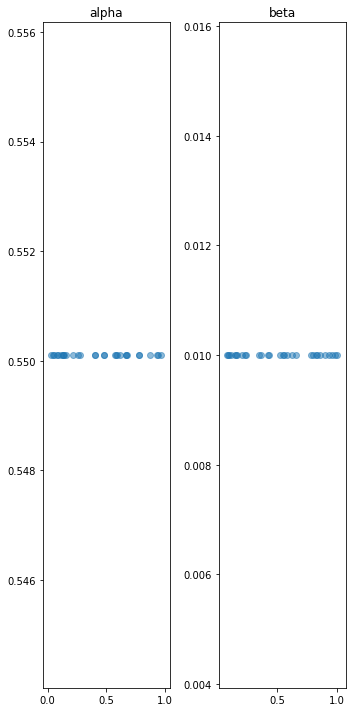

In [44]:
scatter(param_rcv)

In [45]:
def correlation(x, y):
    cor, p = scipy.stats.pearsonr(x, y)
    return cor, p


\begin{equation}
\text{BIC} = - 2 \log p(D\mid {\widehat {\theta }},M) + k \log(T)
\end{equation}

In [46]:
def bic(ll, k, n_iteration):
    return -2 *ll + k * np.log(n_iteration)